$$
\newcommand{\ped}[1]{_{\mathrm{#1}}}
\newcommand{\ap}[1]{^{\mathrm{#1}}}
\newcommand{\nvector}[1]{\mathbf{#1}}
\newcommand{\nmatrix}[1]{\mathit{#1}}
\newcommand{\unitvector}[1]{\hat{\nvector{e}}_{#1}}
\newcommand{\volume}{\mathcal{V}}
\newcommand{\average}[1]{\overline{#1}}
\newcommand{\rate}[1]{\dot{#1}}
\newcommand{\flux}[1]{{#1}''}
\newcommand{\curl}[1]{\nabla\times {#1}}
\newcommand{\curlv}[1]{\curl{\nvector{#1}}}
\newcommand{\divergent}[1]{\nabla \cdot #1}
\newcommand{\divergentv}[1]{\divergent{\nvector{#1}}}
\newcommand{\divergentpar}[1]{\divergent{\left( #1 \right)}}
\newcommand{\gradient}[1]{\nabla {#1}}
\newcommand{\gradientpar}[1]{\gradient{\left( {#1} \right)}}
\newcommand{\laplacian}[1]{\nabla^2 #1}
\newcommand{\laplacianpar}[1]{\laplacian{\left( #1 \right)}}
\newcommand{\vectornorm}[1]{\left\lVert #1 \right\rVert}
\newcommand{\diffp}[2]{\frac{\partial {#1}}{\partial {#2}}}
\newcommand{\diffps}[2]{\frac{\partial^2 {#1}}{\partial {#2}^2}}
\newcommand{\rvec}{\nvector{r}}
\newcommand{\nvh}{\nvector{H}}
\newcommand{\nvb}{\nvector{B}}
\newcommand{\nvrem}{\nvector{B}\ped{rem}}
\newcommand{\nvbrem}{\nvrem}
\newcommand{\nvm}{\nvector{M}}
\newcommand{\mur}{\mu\ped{r}}
\newcommand{\nvbremhat}{\hat{\nvector{B}}\ped{rem}}
\newcommand{\acoef}[2]{a_{{#1},\mathrm{#2}}}
\newcommand{\bcoef}[2]{b_{{#1},\mathrm{#2}}}
\newcommand{\Azexpr}[1]{A_{\mathrm{#1}\, z}}
\newcommand{\bremii}{B_{\mathrm{rem,II}}}
\newcommand{\bremiv}{B_{\mathrm{rem,IV}}}
\newcommand{\aIII}{\acoef{1}{III}}
\newcommand{\bIII}{\bcoef{1}{III}}
\newcommand{\nvbIII}{\nvector{B}\ped{III}}
\newcommand{\BIII}{B\ped{III}}
\newcommand{\diffd}[1]{\mathrm{d}\,{#1}}
$$

# TeslaMax Optimization

Teslamax model:

<img src="figures/teslamax.png" width=500>

We are intererested in finding the optimal set of remanence angles $\alpha_{\mathrm{rem},m,k}$ that will maximize some metric in the air gap.

In [1]:
from pathlib import Path
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel



mpl_params = {'text.usetex': True,
              'font.family': 'serif',
              'font.serif': 'Computer Modern',
              'text.latex.preamble': [r'\usepackage{engsymbols}',
                                      r'\usepackage{magref}',
                                      r'\usepackage{siunitx}']}
matplotlib.rcParams.update(mpl_params)

In [2]:
FIGSIZE_CM = 20
FIGSIZE_INCHES = FIGSIZE_CM / 2.54

FONTSIZE = 20



PAPER_FILE_PATH = Path('.')
FIGURES_DIR_NAME = "figures"
FIG_FILE_PATH = PAPER_FILE_PATH / Path(FIGURES_DIR_NAME)


PLOT_EXTENSION = ".png"

DPI = 800

In [3]:
os.chdir('C:\\Users\\fabiofortkamp\\code\\TeslaMax\\')

In [4]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

In [5]:
import importlib
importlib.reload(teslamax)

<module 'teslamax' from 'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\teslamax\\__init__.py'>

In [6]:
def save_figure(fig,name):
    """
    Save the 'fig' Figure object as 'name' (with extension PLOT_EXTENSION), inside FIG_FILE_PATH,
    and close the figure"""
    
    
    file_path = str(FIG_FILE_PATH / (name + PLOT_EXTENSION))
    fig.savefig(file_path,dpi=DPI,bbox_inches='tight')

## Parameters

This is reference set of parameters that we use to test the optimization procedures:

In [6]:
params_optimization = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "B_rem_II_2": 1.4,
                "B_rem_II_3": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "B_rem_IV_2": 1.4,
                "B_rem_IV_3": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

alpha_B_rem_0 = [15,30,45,15,45,135]


## Principle of superposition and the contribution of each segment

The code below calculate the individual contributions for each magnet block. For instance, the i-th element of the variable `F_II_x` is a list of points in the form $(B_x, B_y)$, calculated in a mesh in the air gap, where only the i-th segment in magnet II has a non-null remanence, with magnitude included in the above dictionary and oriented in the $x$ direction.

This code generates a "mesh" in the upper half-circle (corresponding to the model that is actually simulated by COMSOL), and calculate the $F$-operators in this mesh

In [7]:
%xmode verbose

tmpd = TeslaMaxPreDesign(params_optimization)

F_II_x, F_II_y, F_IV_x, F_IV_y = tmpd.get_F_operators()

Exception reporting mode: Verbose


Each of of the $F$-operators is a list of points, corresponding to the vector $\nvb$ that calculated at `points_air_gap`:

In [8]:
F_IV_x[0]

array([[  5.62015350e-01,   1.05083467e-03],
       [  5.60893057e-01,   5.05093507e-03],
       [  5.59796749e-01,   9.25624858e-03],
       ..., 
       [  5.55450311e-01,   3.03997685e-03],
       [  5.55149676e-01,   1.46620799e-03],
       [  5.54868870e-01,  -1.24096240e-04]])

## Calculating the functional

The basic computational implementation of optimization algorithms require evaluate an *objective functional*. In this formulation, the main optimization variables are the angles, which are always represented by the vector `alpha_B_rem`. Notice that, in order to efficiently calculate the functional, we have to pass the lists of $F$-operators that we calculated previously, the points where these operators are calculated, and the dictionary of parameters.

Our goal is to build an instantaneous profile. This function calculates it:

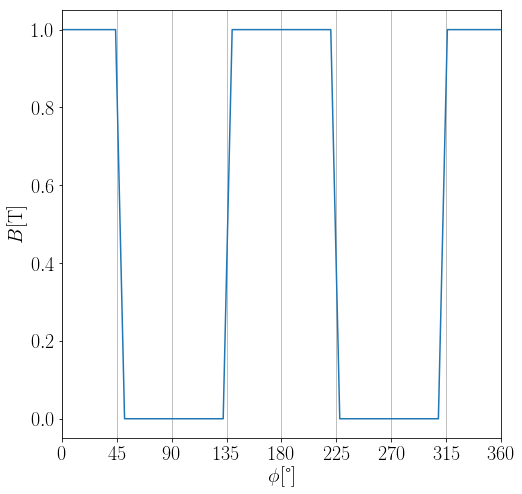

In [9]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)

phi_inst_vector = np.linspace(0,360)
B_inst_vector = teslamax.calculate_instantaneous_profile(phi_inst_vector,1.0)


profile_axes.plot(phi_inst_vector,B_inst_vector)
profile_axes.set_xlim(0,np.max(phi_inst_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_inst_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')




An example of calculation:

In [10]:
S_0 = tmpd.calculate_functional(alpha_B_rem_0)
print(S_0)

20.9162029699


Another piece of optimization algorithm is a function to calculate the derivative of the funcional:

In [11]:
dS_0 = tmpd.calculate_functional_derivative(alpha_B_rem_0, 2)
print(dS_0)

0.068704295586


### Gradients and hessian

In [12]:
grad_K = tmpd.calculate_functional_gradient(alpha_B_rem_0)
print(grad_K)

[-0.00617534 -0.05236675  0.0687043   0.08475899  0.18841937  0.37188602]


In [13]:
hessian_K = tmpd.calculate_functional_hessian(alpha_B_rem_0)
print(hessian_K)

[[ 0.00355271 -0.00355271  0.          0.00355271 -0.00710543  0.00355271]
 [-0.00355271  0.         -0.00355271 -0.00355271 -0.01065814  0.        ]
 [ 0.         -0.00355271  0.         -0.00355271 -0.00710543  0.        ]
 [ 0.00355271 -0.00355271 -0.00355271  0.00355271  0.          0.        ]
 [-0.00710543 -0.01065814 -0.00710543  0.         -0.00355271  0.        ]
 [ 0.00355271  0.          0.          0.          0.          0.01065814]]


In [14]:
np.linalg.eigvals(hessian_K)

array([-0.01880774, -0.00281457,  0.00399163,  0.00751516,  0.01319103,
        0.01113534])

## Optimization algorithm

This is a prototype of an implementation of the gradient descent algorithm from Insinga (2016):

In [16]:
params_optimization = {"R_i": 0.015,
                "R_o": 0.060,
                "h_gap": 0.030,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "B_rem_II_2": 1.4,
                "B_rem_II_3": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "B_rem_IV_2": 1.4,
                "B_rem_IV_3": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }
alpha_B_rem_0 = [15,30,45,15,45,135]

tmpd = TeslaMaxPreDesign(params_optimization)

S_0 = tmpd.calculate_functional(alpha_B_rem_0)

gamma = 1e5
max_iter = 50
tol = 1e-6

i = 0
alpha_B_rem = alpha_B_rem_0.copy()
S_old = S_0

for i in range(0,len(alpha_B_rem)):
    
    it_count = 0
    
    
    while True:
        
        dSdalpha = tmpd.calculate_functional_derivative(alpha_B_rem, i)
        
        dalpha = gamma * dSdalpha
        alpha_B_rem[i] = alpha_B_rem[i] + dalpha
        
        S = tmpd.calculate_functional(alpha_B_rem)
        
        dS_rel = abs((S - S_old)/S)
        S_old = S
        
        
        it_count = it_count + 1
        
        max_iter_reached = it_count >= max_iter
        converged = dS_rel < tol
        
        if converged or max_iter_reached:
            break
            
    print("alpha[%d] = %.2f, S = %.7f" %(i, alpha_B_rem[i],S))


alpha[0] = 20.02, S = 0.0478426
alpha[1] = 70.85, S = 0.0502304
alpha[2] = 5.52, S = 0.0553456
alpha[3] = 45.06, S = 0.0423122
alpha[4] = 43.37, S = 0.0426643
alpha[5] = 110.38, S = 0.0591668


Checking optimality conditions:

In [17]:
grad_alpha_optimal = tmpd.calculate_functional_gradient(alpha_B_rem)
print(grad_alpha_optimal)

[  9.37093458e-06  -1.46938871e-04  -1.13317668e-04  -9.67260876e-04
  -2.51124795e-04  -5.99582217e-04]


In [18]:
hessian_alpha_optimal = tmpd.calculate_functional_hessian(alpha_B_rem)
print(np.linalg.eigvals(hessian_alpha_optimal))


[ -1.23422732e-04   5.02900917e-05   1.41384317e-05  -4.51537145e-05
  -1.01347036e-05  -2.44952511e-05]


We can see that the calculated point is far from optimal, because it is not a stationary point (its gradient is not null) and the hessian matrix is indefinite.

To compare, we plot the magnetic profiles before and after the optimization:

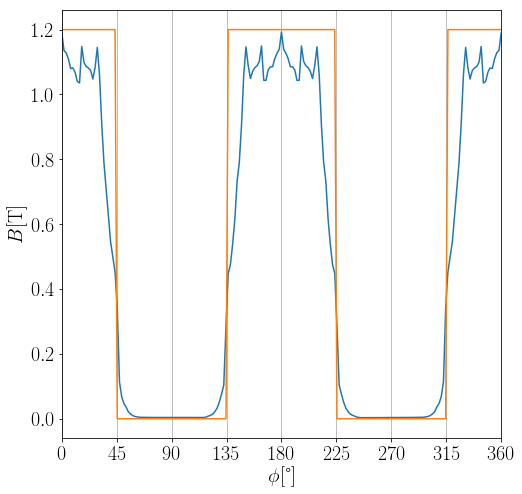

In [15]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)


teslamax_playground = 'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\teslamax-play'
tmpd_reference = TeslaMaxPreDesign(params_optimization)

tmm_reference = TeslaMaxModel(tmpd_reference,alpha_B_rem_0,
                   path=teslamax_playground)
tmm_reference.run()
phi_vector, B_vector = tmm_reference.get_profile_data().T

profile_axes.plot(phi_vector,B_vector)
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = teslamax.calculate_instantaneous_profile(phi_vector,teslamax.TARGET_PROFILE)
profile_axes.plot(phi_vector,B_inst_vector)

In [16]:
teslamax.calculate_average_high_field(tmm_reference.get_profile_data())

0.94677600222222191

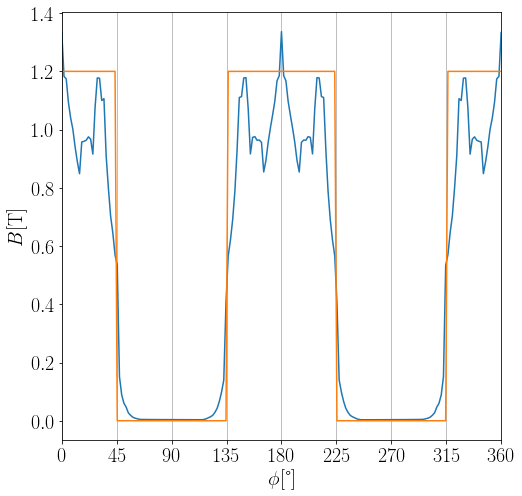

In [17]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)


teslamax_playground = 'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\teslamax-play'

tmm_optimized = TeslaMaxModel(tmpd_reference,alpha_B_rem,
                   path=teslamax_playground)
tmm_optimized.run()
phi_vector, B_vector = tmm_optimized.get_profile_data().T

profile_axes.plot(phi_vector,B_vector)
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = teslamax.calculate_instantaneous_profile(phi_vector,teslamax.TARGET_PROFILE)
profile_axes.plot(phi_vector,B_inst_vector)

In [18]:
teslamax.calculate_average_high_field(tmm_optimized.get_profile_data())

0.95324014444444427

## Optimization using Scipy

In [7]:
params_optimization = {"R_i": 0.015,
                "R_o": 0.060,
                "h_gap": 0.030,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "B_rem_II_2": 1.4,
                "B_rem_II_3": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "B_rem_IV_2": 1.4,
                "B_rem_IV_3": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }
alpha_B_rem_0 = [15,30,45,15,45,135]

n = len(alpha_B_rem_0)

tmpd = TeslaMaxPreDesign(params_optimization)

In [8]:
%%time 
## all this methods from the TeslaMaxPreDesign class accept as only arguments the design vector (with remanence angles)

objective_function = tmpd.calculate_functional

jac = tmpd.calculate_functional_gradient

hess = tmpd.calculate_functional_hessian

#bounds = [(0.0, 360.0) for i in range(0,n)]

res = minimize(objective_function, alpha_B_rem_0, options={'disp': True})

Optimization terminated successfully.
         Current function value: 25.566692
         Iterations: 54
         Function evaluations: 464
         Gradient evaluations: 58
Wall time: 6min 59s


In [9]:
res.x

array([ -3.72561783,   4.89731892, -15.79428618,   8.21148059,
        30.85165973,  87.03828477])

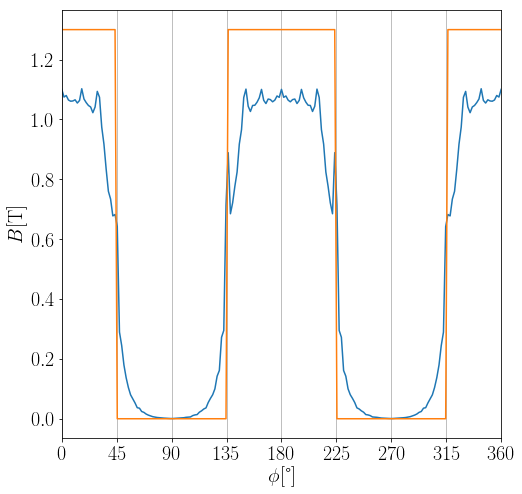

In [10]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)


teslamax_playground = 'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\teslamax-play'

tmm_optimized = TeslaMaxModel(tmpd,res.x,
                   path=teslamax_playground)
tmm_optimized.run()
phi_vector, B_vector = tmm_optimized.get_profile_data().T

profile_axes.plot(phi_vector,B_vector)
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = teslamax.calculate_instantaneous_profile(phi_vector,teslamax.TARGET_PROFILE)
profile_axes.plot(phi_vector,B_inst_vector)

save_figure(profile_fig,"profile_optimized_B_13")

In [11]:
teslamax.calculate_average_high_field(tmm_optimized.get_profile_data())

0.96900752999999973

In [12]:
tmpd.calculate_functional_gradient(res.x)

array([ -1.41398004e-06,  -1.77635684e-07,   1.70530257e-07,
        -2.94875235e-06,   1.48148160e-06,  -1.56319402e-07])

In [13]:
np.linalg.eigvals(tmpd.calculate_functional_hessian(res.x))

array([-0.01436918,  0.02501274, -0.00365984,  0.01439269,  0.00799387,
        0.00260413])

In [14]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

## Optimization using evolutionary algorithms

In [7]:
from scipy.optimize import differential_evolution, basinhopping

In [8]:
params_optimization = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "B_rem_II_2": 1.4,
                "B_rem_II_3": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "B_rem_IV_2": 1.4,
                "B_rem_IV_3": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }
alpha_B_rem_0 = [15,30,45,15,45,135]

n = len(alpha_B_rem_0)

tmpd = TeslaMaxPreDesign(params_optimization)

In [10]:
%%time 
## all this methods from the TeslaMaxPreDesign class accept as only arguments the design vector (with remanence angles)

objective_function = tmpd.calculate_functional

bounds = [(0.0, 360.0) for i in range(0,n)]

res = differential_evolution(objective_function,bounds,disp=True)

differential_evolution step 1: f(x)= 41.7747
differential_evolution step 2: f(x)= 32.0131
differential_evolution step 3: f(x)= 32.0131
differential_evolution step 4: f(x)= 25.6068
differential_evolution step 5: f(x)= 25.2199
differential_evolution step 6: f(x)= 23.1237
differential_evolution step 7: f(x)= 23.1237
differential_evolution step 8: f(x)= 23.1237
differential_evolution step 9: f(x)= 23.1237
differential_evolution step 10: f(x)= 23.1237
differential_evolution step 11: f(x)= 17.4902
differential_evolution step 12: f(x)= 17.4902
differential_evolution step 13: f(x)= 17.4902
differential_evolution step 14: f(x)= 17.4902
differential_evolution step 15: f(x)= 17.4902
differential_evolution step 16: f(x)= 16.5904
differential_evolution step 17: f(x)= 15.9128
differential_evolution step 18: f(x)= 15.8982
differential_evolution step 19: f(x)= 15.3236
differential_evolution step 20: f(x)= 15.3236
differential_evolution step 21: f(x)= 15.3236
differential_evolution step 22: f(x)= 15.32

In [13]:
res.x

array([ 173.28273025,  194.4825884 ,  176.87603619,  186.30206755,
        203.81412089,  258.53718731])

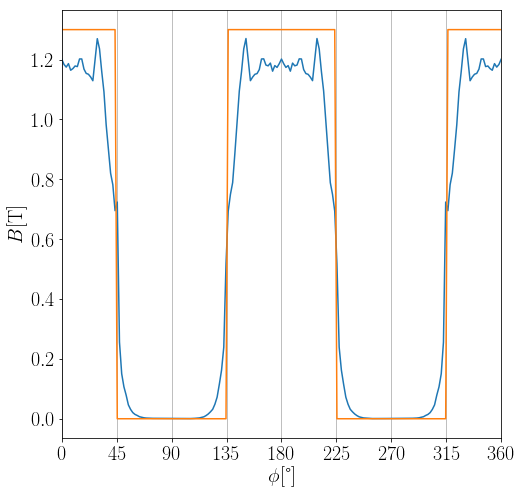

In [15]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)


teslamax_playground = 'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\teslamax-play'

tmm_optimized = TeslaMaxModel(tmpd,res.x,
                   path=teslamax_playground)
tmm_optimized.run()
phi_vector, B_vector = tmm_optimized.get_profile_data().T

profile_axes.plot(phi_vector,B_vector)
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = teslamax.calculate_instantaneous_profile(phi_vector,teslamax.TARGET_PROFILE)
profile_axes.plot(phi_vector,B_inst_vector)

save_figure(profile_fig,"profile_optimized_genetic_B_13")

In [16]:
teslamax.calculate_average_high_field(tmm_optimized.get_profile_data())

1.0797673144444442

In [17]:
tmpd.calculate_functional_gradient(res.x)

array([  3.68931552e-04,   8.03979106e-05,   1.31567646e-04,
        -3.09608339e-04,  -9.20538312e-04,  -7.93072275e-05])

In [18]:
np.linalg.eigvals(tmpd.calculate_functional_hessian(res.x))

array([ 0.01703353, -0.00148553,  0.00217259,  0.01196262,  0.00870582,
        0.00601989])